<a href="https://colab.research.google.com/github/kirath2205/Neural-Network-Assignment-1/blob/main/start_1a.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow
import pandas as pd
import time
import numpy as np
import statistics

# tensorflow libraries
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout,Input

# sklearn libraries are useful for preprocessing, performance measures, etc.
from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

# Read Data

In [2]:
df = pd.read_csv('./features_30_sec.csv')

In [3]:
df['label'].value_counts()

hiphop       100
classical    100
jazz         100
country      100
disco        100
reggae       100
metal        100
blues        100
rock         100
pop          100
Name: label, dtype: int64

#Question 1


In [4]:
columns_to_drop = ['label','filename', 'length']

def prepare_dataset_question1(df, columns_to_drop, test_size, random_state):

    # Encode the labels from 0 to n_classes-1  
    label_encoder = preprocessing.LabelEncoder()
    df['label'] = label_encoder.fit_transform(df['label'])
  
    # devide data to train and test
    df_train, df_test = train_test_split(df, test_size=test_size, random_state=random_state)
    
    # scale the training inputs
    x_train = df_train.drop(columns_to_drop,axis=1)
    y_train = df_train['label'].to_numpy()
    
    standard_scaler = preprocessing.StandardScaler()
    x_train_scaled = standard_scaler.fit_transform(x_train)

    #scale and prepare testing data
    x_test = df_test.drop(columns_to_drop,axis=1)
    x_test_scaled = standard_scaler.transform(x_test)
    y_test = df_test['label'].to_numpy() 
  
    return x_train_scaled, y_train, x_test_scaled, y_test

In [5]:
X_train, y_train, X_test, y_test = prepare_dataset_question1(df, columns_to_drop, test_size=0.3, random_state=0)


In [6]:
def build_model(total_classes,input_shape,hidden_layer_neurons=16,hidden_layers=1,need_drop_out=True,dropout_probability=0.3,optimizer='adam'):

  model=tf.keras.models.Sequential()
  model.add(keras.layers.Input(shape=input_shape))
  for i in range(hidden_layers):
    model.add(keras.layers.Dense(hidden_layer_neurons, activation="relu"))
    if(need_drop_out):
      model.add(keras.layers.Dropout(dropout_probability))
  model.add(keras.layers.Dense(total_classes, activation='softmax'))
  model.compile(optimizer=optimizer,metrics=['accuracy'],loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True))

  return model

def train_model(model,epochs,X_train,y_train,X_test,y_test,batch_size=1,callbacks=[]):

  history=model.fit(X_train,y_train,epochs=epochs,batch_size=batch_size,validation_data=(X_test,y_test),callbacks=callbacks)
  return history


In [ ]:
history={}
model=build_model(10,X_train[0].shape)
history['question-1']=train_model(model,50,X_train,y_train,X_test,y_test)

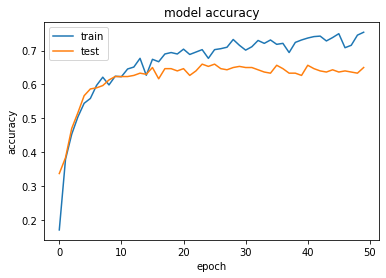

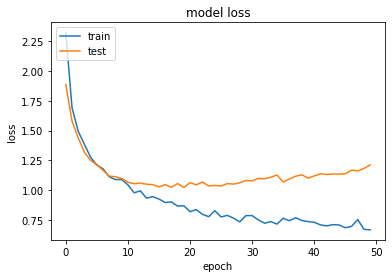

In [8]:
plt.plot(history['question-1'].history['accuracy'])
plt.plot(history['question-1'].history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history['question-1'].history['loss'])
plt.plot(history['question-1'].history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#Question 2

In [9]:
def prepare_dataset_question2(df, columns_to_drop):

  label_encoder = preprocessing.LabelEncoder()
  df['label'] = label_encoder.fit_transform(df['label'])

  X = df.drop(columns_to_drop,axis=1)
  Y = df['label'].to_numpy()

  standard_scaler = preprocessing.StandardScaler()
  X_scaled = standard_scaler.fit_transform(X)

  return X_scaled,Y

class TimeHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.times = []
    def on_epoch_begin(self, batch, logs={}):
        self.epoch_time_start = time.time()
    def on_epoch_end(self, batch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)

In [ ]:
X , Y = prepare_dataset_question2(df , columns_to_drop)
n_splits=3
kf = KFold(n_splits=n_splits)

batch_sizes=[1,4,8,16,32,64]
total_classes=10
input_shape=X[0].shape
history={}
k_fold=1
epochs=50
epoch_times={}

for element in batch_sizes:

  epoch_times[element]=[]

for train,test in kf.split(X):

  X_train , X_test = X[train] , X[test]
  y_train , y_test = Y[train] , Y[test]

  for batch_size in batch_sizes:

    model=build_model(total_classes,input_shape)
    time_callback = TimeHistory()
    history[(batch_size,k_fold)] = train_model(model,epochs,X_train,y_train,X_test,y_test,batch_size,[time_callback])

    for element in time_callback.times:
      epoch_times[batch_size].append(element)

  k_fold+=1

In [ ]:
mean_cross_validation_accuracies=[]
'''for batch_size in batch_sizes:
  temp=[]
  for key in history.keys():
    if(key[0]==batch_size):
      temp.append(history[key].history['val_accuracy'])
  mean_accuracy=[0]*epochs
  for element in temp:
    for epoch in range(epochs):
      mean_accuracy[epoch]+=element[epoch]
  for epoch in range(epochs):
    mean_accuracy[epoch]=mean_accuracy[epoch]/n_splits
  mean_cross_validation_accuracies.append(mean_accuracy)'''
for batch_size in batch_sizes:
  temp=[]

  for k_fold in range(1,4):
    temp.append(history[batch_size,k_fold])

  mean_accuracy=[0]*epochs

  for list1 in temp:
    for epoch in range(len(list1)):
      mean_accuracy[epoch]+=list1[epoch]
  
  for i in range(epochs):
    mean_accuracy[i]=mean_accuracy[i]/3
  mean_cross_validation_accuracies.append(mean_accuracy.copy())


In [ ]:
epoch_list=[(i+1) for i in range(epochs)]
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.title('mean cross-validation accuracies for different batch-sizes')
for index in range(len(batch_sizes)):
  batch_size=batch_sizes[index]
  mean_accuracy_list=mean_cross_validation_accuracies[index]
  plt.plot(epoch_list, mean_accuracy_list, label = 'batch size of '+str(batch_sizes[index]))
  plt.legend()
  plt.show()

In [ ]:
median_epoch_times={}
for batch_size in epoch_times.keys():
  median_epoch_times[batch_size]=float("{:.2f}".format(statistics.median(epoch_times[batch_size])))
median_epoch_time_table=pd.DataFrame(median_epoch_times.items(),columns=['Batch_size','Mean_time'])

In [ ]:
median_epoch_time_table.index = median_epoch_time_table.index + 1
median_epoch_time_table

In [ ]:
plt.xlabel('epochs')
plt.ylabel('accuracy')
optimal_batch_size=64
train_accuracy=[0]*epochs
test_accuracy=[0]*epochs
temp_train_accuracy=[]
temp_test_accuracy=[]
for key in history.keys():
  if(key[0]==optimal_batch_size):
    temp_train_accuracy.append(history[key].history['accuracy'])
    temp_test_accuracy.append(history[key].history['val_accuracy'])
for i in range(n_splits):
  for epoch in range(epochs):
    train_accuracy[epoch]+=temp_train_accuracy[i][epoch]
    test_accuracy[epoch]+=temp_test_accuracy[i][epoch]
for epoch in range(epochs):
  train_accuracy[epoch]=train_accuracy[epoch]/n_splits
  test_accuracy[epoch]=test_accuracy[epoch]/n_splits

plt.title('test and train accuracy for batch size - '+str(optimal_batch_size))
plt.plot(epoch_list,train_accuracy,label='training accuracy')
plt.plot(epoch_list,test_accuracy,label='test accuracy')


    

#Question 3


In [ ]:
hidden_layer_neuron_list=[8, 16, 32, 64]
for train,test in kf.split(X):

  X_train , X_test = X[train] , X[test]
  y_train , y_test = Y[train] , Y[test]

  for hidden_layer_neurons in hidden_layer_neuron_list:

    model=build_model(total_classes,input_shape,hidden_layer_neurons)
    history[(hidden_layer_neurons,k_fold)] = train_model(model,epochs,X_train,y_train,X_test,y_test,optimal_batch_size,[time_callback])

  k_fold+=1

In [ ]:
mean_cross_validation_accuracies=[]
for hidden_layer_neurons in hidden_layer_neuron_list:
  temp=[]
  for key in history.keys():
    if(key[0]==hidden_layer_neurons):
      temp.append(history[key].history['val_accuracy'])
  mean_accuracy=[0]*epochs
  for element in temp:
    for epoch in range(epochs):
      mean_accuracy[epoch]+=element[epoch]
  for epoch in range(epochs):
    mean_accuracy[epoch]=mean_accuracy[epoch]/n_splits
  mean_cross_validation_accuracies.append(mean_accuracy)

In [ ]:
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.title('mean cross-validation accuracies for different batch-sizes')
for index in range(len(hidden_layer_neuron_list)):
  hidden_layer_neurons=hidden_layer_neuron_list[index]
  mean_accuracy_list=mean_cross_validation_accuracies[index]
  plt.plot(epoch_list, mean_accuracy_list, label = 'Total hidden neurons of '+str(hidden_layer_neuron_list[index]))
  plt.legend()
  plt.show()

In [ ]:
plt.xlabel('epochs')
plt.ylabel('accuracy')
optimal_neurons=64
train_accuracy=[0]*epochs
test_accuracy=[0]*epochs
temp_train_accuracy=[]
temp_test_accuracy=[]
history={}
for key in history.keys():
  if(key[0]==optimal_neurons):
    temp_train_accuracy.append(history[key].history['accuracy'])
    temp_test_accuracy.append(history[key].history['val_accuracy'])
for i in range(n_splits):
  for epoch in range(epochs):
    train_accuracy[epoch]+=temp_train_accuracy[i][epoch]
    test_accuracy[epoch]+=temp_test_accuracy[i][epoch]
for epoch in range(epochs):
  train_accuracy[epoch]=train_accuracy[epoch]/n_splits
  test_accuracy[epoch]=test_accuracy[epoch]/n_splits

plt.title('test and train accuracy for '+str(optimal_neurons)+' neurons')
plt.plot(epoch_list,train_accuracy,label='training accuracy')
plt.plot(epoch_list,test_accuracy,label='test accuracy')


#Question-4

In [ ]:
X_train, y_train, X_test, y_test = prepare_dataset_question1(df, columns_to_drop, test_size=0.3, random_state=0)
total_classes=10
image_shape=X_train[0].shape
hidden_layers=2
history={}
batch_size=1
model=build_model(total_classes,image_shape,optimal_neurons,hidden_layers)
history['question-4']=train_model(model,50,X_train,y_train,X_test,y_test,batch_size)

In [ ]:
plt.plot(history['question-4'].history['accuracy'])
plt.plot(history['question-4'].history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#Question-5


In [ ]:
X_train, y_train, X_test, y_test = prepare_dataset_question1(df, columns_to_drop, test_size=0.3, random_state=0)

In [ ]:
history={}
model=build_model(10,X_train[0].shape)
hidden_layer_neurons=16
hidden_layers=1
epochs=50
total_classes=10
need_drop_out=False
input_shape=X_train[0].shape
batch_size=1
model=build_model(total_classes,input_shape,hidden_layer_neurons,hidden_layers,need_drop_out)
history={}
history['question-5']=train_model(model,50,X_train,y_train,X_test,y_test,batch_size)

In [ ]:
plt.plot(history['question-5'].history['accuracy'])
plt.plot(history['question-5'].history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history['question-5'].history['loss'])
plt.plot(history['question-5'].history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()